# Mass Spec Data Analysis

In [1]:
# First, we must perform the incantations.
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Parse data file.
proteins = pd.read_table('data/pubs2015/proteinGroups.txt', low_memory=False)

# Find mass spec intensity columns.
intensity_cols = [c for c in proteins.columns if 'intensity '
            in c.lower() and 'lfq' not in c.lower()]

# Find columns corresponding to experiment classes.
wcl_cols = [c for c in intensity_cols if '_wcl' in c.lower() and '_wclp' not in c.lower()]
wclp_cols = [c for c in intensity_cols if '_wclp' in c.lower()]
ub_cols = [c for c in intensity_cols if '_ub' in c.lower() and '_ubp' not in c.lower()]
ubp_cols = [c for c in intensity_cols if '_ubp' in c.lower()]

# Create a binary mask excluding reversed and contaminated samples.
mask = (proteins['Reverse'] != '+') & \
       (proteins['Potential contaminant'] != '+')

## Relative intensity
Every MS run has a characteristic intensity scale depending on the quantity of sample, concentration of cells / protein and probably other things.

Before further analysis we compute relative intensity based on the total intensity in each MS run.

In [3]:
# Apply reversed/contaminated mask and get intensity columns.
intensities = proteins[mask][intensity_cols]
# Sum down the columns (MS runs).
total_intensities = proteins[intensity_cols].sum(axis=0)
# Element-wise division with singleton expansion/broadcasting.
normed_intensities = intensities / total_intensities

In [5]:
# Indices of proteins which have non-zero intensity in at least one run.
idx = (normed_intensities != 0).any(axis=1)

# Get names and intensities of such proteins.
names = proteins[mask][idx]['Protein IDs']
nonzero_intensities = normed_intensities[idx]

# Separate the intensity DataFrame into separate DataFrames for each experiment class.
wcl = nonzero_intensities[wcl_cols]
wclp = nonzero_intensities[wclp_cols]
ub = nonzero_intensities[ub_cols]
ubp = nonzero_intensities[ubp_cols]

In [6]:
# Find control columns in each experiment class.
wcl_ctrl = [c for c in wcl.columns if 'control' in c.lower()]
wclp_ctrl = [c for c in wclp.columns if 'control' in c.lower()]
ub_ctrl = [c for c in ub.columns if 'control' in c.lower()]
ubp_ctrl = [c for c in ubp.columns if 'control' in c.lower()]

# Find experiment columns in each experiment class.
wcl_exp = [c for c in wcl.columns if 'control' not in c.lower()]
wclp_exp = [c for c in wclp.columns if 'control' not in c.lower()]
ub_exp = [c for c in ub.columns if 'control' not in c.lower()]
ubp_exp = [c for c in ubp.columns if 'control' not in c.lower()]


## Fold-change
Compute base-2 logarithm of the experiment : control ratios for each protein and experiment class.

These values represent the "fold change" from control in each of the experiments.

In [7]:
# Need to use underlying numpy arrays for singleton expansion ('broadcasting')
# and form new DataFrame using appropriate column names.
wcl_foldch = pd.DataFrame(log2(wcl[wcl_exp]).values - log2(wcl[wcl_ctrl]).values, columns=wcl_exp)
wclp_foldch = pd.DataFrame(log2(wclp[wclp_exp]).values - log2(wclp[wclp_ctrl]).values, columns=wclp_exp)
ub_foldch = pd.DataFrame(log2(ub[ub_exp]).values - log2(ub[ub_ctrl]).values, columns=ub_exp)
ubp_foldch = pd.DataFrame(log2(ubp[ubp_exp]).values - log2(ubp[ubp_ctrl]).values, columns=ubp_exp)


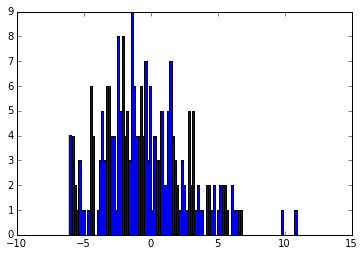

In [10]:
# 3rd-to-last element is Shmoo / CaCl2.
# Only histogram finite (non-inf, non-NaN) values.
hist(wcl_foldch[wcl_foldch.columns[-3]][isfinite(wcl_foldch[wcl_foldch.columns[-3]])].values, 100);